## MAD GAN

In [1]:
# Initialization of libraries
import torch
import torch.nn
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import random
from random import randint
from sklearn.mixture import GMM
device = torch.device('cuda')
%matplotlib inline

In [2]:
# defining parameters for the training
mb_size = 128 # Batch Size
Z_dim = 64  # Length of noise vector
X_dim = 1  # Input Length
h_dim = 128  # Hidden Dimension
lr = 1e-4    # Learning Rate
num_gen = 4

/home/shyam.nandan/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)


(array([ 1.,  0.,  0., ...,  0.,  0.,  1.]),
 array([  0.00000000e+00,   5.00000000e-06,   1.00000000e-05, ...,
          9.99990000e-01,   9.99995000e-01,   1.00000000e+00]),
 <a list of 1 Patch objects>)

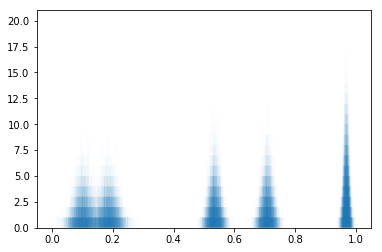

In [3]:
np.random.seed(1)
gmm = GMM(5)
gmm.means_ = np.array([[10], [20], [60], [80], [110]])
gmm.covars_ = np.array([[3], [3], [2], [2], [1]]) ** 2
gmm.weights_ = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

X = gmm.sample(200000)
data = X
data = (data - X.min())/(X.max()-X.min())
plt.hist(data, 200000, normed=False, histtype='stepfilled', alpha=1)

In [4]:
G = []
for i in range(num_gen):
    G.append(torch.nn.Sequential(
        torch.nn.Linear(Z_dim, h_dim),
        torch.nn.PReLU(),
        torch.nn.Linear(h_dim, h_dim),
        torch.nn.PReLU(),
        torch.nn.Linear(h_dim, X_dim),
        torch.nn.Sigmoid()
    ).cuda())

D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, num_gen + 1),
    torch.nn.Softmax()
).cuda()

In [5]:
G_solver = []
for i in range(num_gen):
    G_solver.append(optim.Adam(G[i].parameters(), lr))
D_solver = optim.Adam(D.parameters(), lr)
###
loss = nn.CrossEntropyLoss()
label_G = Variable(torch.LongTensor(mb_size))
label_G = label_G.to(device)
label_D = Variable(torch.LongTensor(mb_size))
label_D = label_D.to(device)

In [6]:
# Reset the gradients to zero
params = [G[0], G[1], G[2], G[3], D]
def reset_grad():
    for net in params:
        net.zero_grad()
reset_grad()

In [7]:
data_index = 0
for it in range(198000):
    if ((data_index + 1)*mb_size>len(data)):
        data_index = 0

    X = torch.from_numpy(np.array(data[data_index*mb_size : (data_index + 1)*mb_size]))
    X = X.view(mb_size, 1)
    X = X.type(torch.FloatTensor)
    X = X.to(device)
    Total_D_loss = 0
    for i in range(num_gen):
        # Dicriminator forward-loss-backward-update
        #forward pass
        z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
        z = z.to(device)
        G_sample = G[i](z)
        D_real = D(X)
        D_fake = D(G_sample)
        # Calculate the loss
        D_loss_real = loss(D_real,label_D.fill_(num_gen + 0.1*randint(-1,1)))
        D_loss_fake = loss(D_fake, label_G.fill_(i + 0.1*randint(-1,1)))
        D_loss = D_loss_real + D_loss_fake
        Total_D_loss = D_loss + Total_D_loss
        # Calulate and update gradients of discriminator
        D_loss.backward()
        D_solver.step()

        # reset gradient
        reset_grad()

    # Generator forward-loss-backward-update
    
    Total_G_loss = 0
    for i in range(num_gen):
        
        z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
        z = z.to(device)
        G_sample = G[i](z)
        D_fake = D(G_sample)

        G_loss = loss(D_fake, label_D.fill_(num_gen + 0.1*randint(-1,1)))
        Total_G_loss = G_loss + Total_G_loss
        G_loss.backward()
        G_solver[i].step()

        # reset gradient
        reset_grad()
        
    data_index = data_index + 1
    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, Total_D_loss.data.cpu().numpy(), Total_G_loss.data.cpu().numpy()))

/home/shyam.nandan/.local/lib/python2.7/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iter-0; D_loss: 12.9841918945; G_loss: 6.5625038147
Iter-1000; D_loss: 11.620013237; G_loss: 4.62081956863
Iter-2000; D_loss: 12.1049785614; G_loss: 5.07273244858
Iter-3000; D_loss: 12.0480041504; G_loss: 4.72685623169
Iter-4000; D_loss: 12.3913974762; G_loss: 4.6692442894
Iter-5000; D_loss: 12.4863376617; G_loss: 4.66399288177
Iter-6000; D_loss: 12.8325176239; G_loss: 4.77811431885
Iter-7000; D_loss: 12.4039382935; G_loss: 5.40031528473
Iter-8000; D_loss: 12.427230835; G_loss: 5.33937358856
Iter-9000; D_loss: 12.3920021057; G_loss: 5.03366661072
Iter-10000; D_loss: 11.9586429596; G_loss: 5.74435377121
Iter-11000; D_loss: 11.9493455887; G_loss: 5.26605272293
Iter-12000; D_loss: 11.7601156235; G_loss: 5.48749637604
Iter-13000; D_loss: 12.0403003693; G_loss: 5.64816570282
Iter-14000; D_loss: 11.8137254715; G_loss: 5.29893398285
Iter-15000; D_loss: 12.6629753113; G_loss: 5.75017023087
Iter-16000; D_loss: 11.9304962158; G_loss: 5.51840591431
Iter-17000; D_loss: 12.0984783173; G_loss: 5.507

Iter-144000; D_loss: 11.8751077652; G_loss: 5.21694421768
Iter-145000; D_loss: 12.2212028503; G_loss: 5.18990898132
Iter-146000; D_loss: 12.7875299454; G_loss: 5.65146493912
Iter-147000; D_loss: 12.1440553665; G_loss: 5.71858596802
Iter-148000; D_loss: 12.7683753967; G_loss: 5.56398439407
Iter-149000; D_loss: 11.9209957123; G_loss: 5.28400421143
Iter-150000; D_loss: 12.2146873474; G_loss: 5.35271167755
Iter-151000; D_loss: 11.8250980377; G_loss: 5.16409873962
Iter-152000; D_loss: 11.8266620636; G_loss: 5.45387029648
Iter-153000; D_loss: 12.2501134872; G_loss: 4.98568868637
Iter-154000; D_loss: 12.2260112762; G_loss: 5.1959271431
Iter-155000; D_loss: 12.3000488281; G_loss: 5.50676441193
Iter-156000; D_loss: 12.2422523499; G_loss: 5.32122325897
Iter-157000; D_loss: 12.8856134415; G_loss: 5.37763023376
Iter-158000; D_loss: 12.4171857834; G_loss: 5.70684957504
Iter-159000; D_loss: 11.3545064926; G_loss: 6.29471683502
Iter-160000; D_loss: 11.5770978928; G_loss: 5.24786806107
Iter-161000; D_

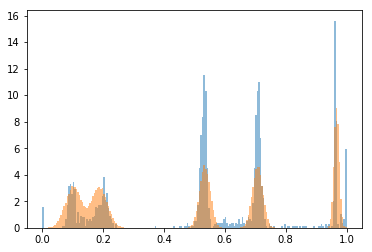

In [11]:
import numpy as np
final = np.zeros(1500*mb_size, dtype = float)
for i in range(1500):
    z = torch.FloatTensor(64, Z_dim).uniform_(-1, 1)
    z = z.to(device)
    l = G[randint(0,num_gen-1)](z).cpu().detach().numpy()
    final[i*mb_size : ((i+ 1)*mb_size -1)] = l[0]
p1 = plt.hist(final, 200, normed=True, histtype='bar', alpha=0.5)
p2 = plt.hist(data, 200, normed=True, histtype='bar', alpha=0.5)

## Points to ponder
1. What happens if we reduce the number of generator?
2. What happens if we change the learning rate and other parameters?
3. What happens if we change the noise distribution?